In [1]:
from __future__ import annotations

import sys
sys.path.append("/media/wdp/disk4/git/noiseba/src") 
import numpy as np
import datetime
import matplotlib.pyplot as plt

from scipy.fft import next_fast_len
from pathlib import Path
from obspy import read


from noiseba.preprocessing import (
    load_stream,
    sliding_window_2d_to_3d, 
    apply_taper,
    ccf, 
    compute_fft, 
    ifft_real_shift, 
    whiten_spectrum, 
    batch_process
    )

from noiseba.utils import (
    plot_ccf,
    snr_optimal_select,
    energy_symmetry_select,
    stream_to_array,
    stack_pws_numba,
    read_stations,
    front_k_pairs,
    build_ccf_index,
    write_front_k_sac,
    
)

from noiseba.dispersion import fj_from_dir, park_from_dir, radon_from_dir

# 1. Preprocess seismic data
- demean, detrend, remove instrment response (optional),  filter, decimiate

In [3]:
st = read(r'/media/wdp/disk4/site1_line1/sw_raw_data/453000030Z.sac')
start_time = st[0].stats.starttime + datetime.timedelta(minutes=2)
end_time = st[0].stats.endtime

input_dir = Path(r'/media/wdp/disk4/site1_line1/sw_raw_data')
out_dir = Path(r'./pre_data')

config = {
    "input_dir": input_dir,
    "output_dir": out_dir,
    "target_rate": 100,      # decimate smapling rate
    "freq_min": 1,            # lower filter
    "freq_max": 45,           # upper filter
    "start_time": start_time, # cut begin
    "end_time": end_time,     # cut end
    "max_workers": 36         # used cpu cores
}

batch_process(**config)


Reading...
---------------Processing 20 Trace-----------------




Processing traces: 100%|██████████| 20/20 [00:00<00:00, 21.46it/s]



-------------------------Done-----------------------------------


# 2. Compute cross correlation function

In [2]:
# load pre-processed data
st = load_stream(r'./pre_data', order_file = 'xy.txt')

data, stations = stream_to_array(st)
dt = st[0].stats.delta

# time segment 
win_len = next_fast_len(int(10 / dt))
step = int(0.5 * win_len) # overlap


data_3D = sliding_window_2d_to_3d(data, win_len, step)
data_3D_taper = apply_taper(data_3D)


# compute ccf
n_fft  = 2 * win_len - 1
F= compute_fft(data_3D_taper, n_fft=n_fft)             # fft
WF = whiten_spectrum(F, smooth_width=5, window='ones') # spectrum whitening
idx, C = ccf(WF)                                       # ccf in frequency domain
ccf3 = ifft_real_shift(C, n_fft=n_fft)                 # ccf in time domain
ccf = stack_pws_numba(ccf3)                            # ccf stacking - no QC

In [3]:
statinfo = read_stations(r'./pre_data/xy.txt')
pairs = front_k_pairs(statinfo, k=len(statinfo)) # Index of cross‑correlation station pairs
ccf_index = build_ccf_index(pairs, statinfo, 0.01, 9.99, "./CCF",  storage_type="sac")
dist = ccf_index['distance'].values

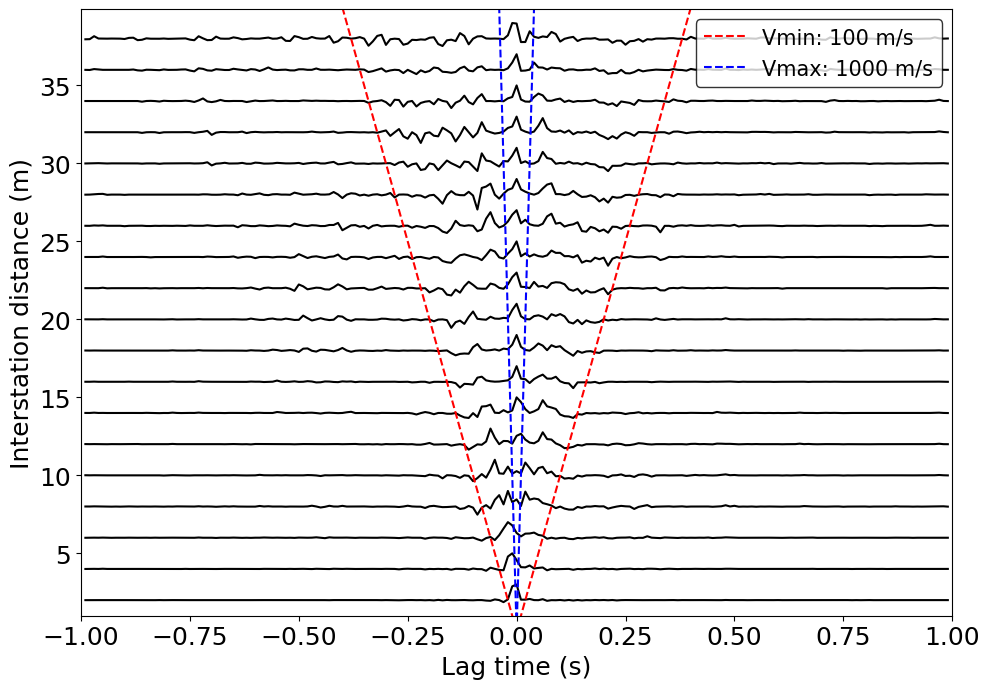

In [4]:
vmin, vmax = 100, 1000  # m/s
plot_ccf(ccf, dist, dt, 1, vmin, vmax)

<h3 style="color:#6A5ACD;">2.1 <b>[Optional]</b> · 
<span style="color:#FF6347;">Cross-Correlation Function (CCF) Quality Control</span></h3>

<p style="color:#444444;">
Before stacking, it is often useful to <b style="color:#2E8B57;">filter out unreliable CCF windows</b>.  
Here we demonstrate two commonly used selection criteria:
</p>

<ul style="color:#333333;">
  <li><span style="color:#1E90FF;"><b>Signal-to-Noise Ratio (SNR)</b></span> — retain windows with sufficiently high SNR values.</li>
  <li><span style="color:#FF8C00;"><b>Energy Symmetry</b></span> — select windows where positive and negative lags show balanced energy distribution.</li>
</ul>

<p style="color:#555555;">
👉 These criteria help ensure that only stable and physically meaningful CCFs are included in the final stack.
</p>


In [5]:
# snr selection
neg_curve, pos_curve, ccf_snr = snr_optimal_select(ccf3, dist, dt, vmin=100, vmax=1000, signal_truncation=False)

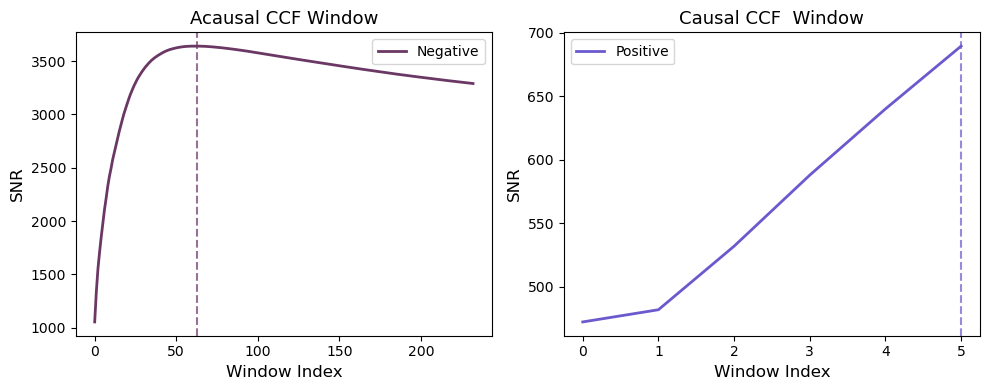

In [6]:
fig, (ax_neg, ax_pos) = plt.subplots(1, 2, figsize=(10, 4))

# --- Acausal CCF ---
ax_neg.plot(neg_curve, color="#6B3764", label="Negative", linewidth=2)
ax_neg.axvline(x=np.argmax(neg_curve), linestyle="--", color="#6B3764", alpha=0.7)
ax_neg.set_xlabel("Window Index", fontsize=12)
ax_neg.set_ylabel("SNR", fontsize=12)
ax_neg.set_title("Acausal CCF Window", fontsize=13)
ax_neg.legend()

# --- Causal CCF ---
ax_pos.plot(pos_curve, color="#6A5ACD", label="Positive", linewidth=2)
ax_pos.axvline(x=np.argmax(pos_curve), linestyle="--", color="#6A5ACD", alpha=0.7)
ax_pos.set_xlabel("Window Index", fontsize=12)
ax_pos.set_ylabel("SNR", fontsize=12)
ax_pos.set_title("Causal CCF  Window", fontsize=13)
ax_pos.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [7]:
# Energy Symmetry
ccf_sym = energy_symmetry_select(ccf3, dist, dt,vmin=100, vmax=1000)

Text(0.5, 1.0, 'Energy Symmetry')

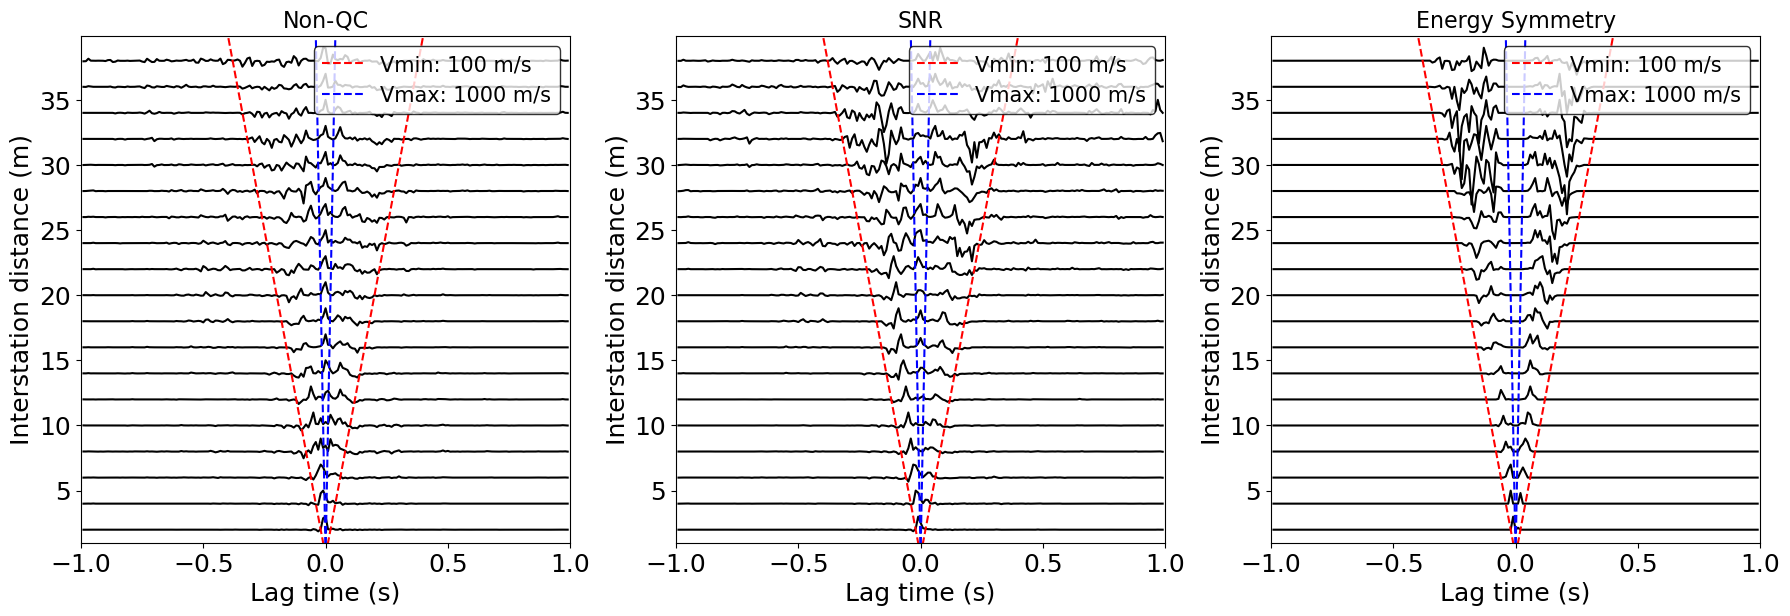

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Non-QC
plot_ccf(ccf, dist, dt, 1, vmin, vmax, axes[0])

# SNR
plot_ccf(ccf_snr, dist, dt, 1, vmin, vmax, axes[1])

# ES
plot_ccf(ccf_sym , dist, dt, 1, vmin, vmax, axes[2])

axes[0].set_title("Non-QC", fontsize=16)
axes[1].set_title("SNR", fontsize=16)
axes[2].set_title("Energy Symmetry", fontsize=16)



### ✅ Let's store the ccf results before and after window selection to see the difference

In [9]:
write_front_k_sac(ccf_snr, pairs, statinfo, 0.01, output_directory="./CCF")

# 3. calculate Dispersion Spectrum

### 👓 Park 

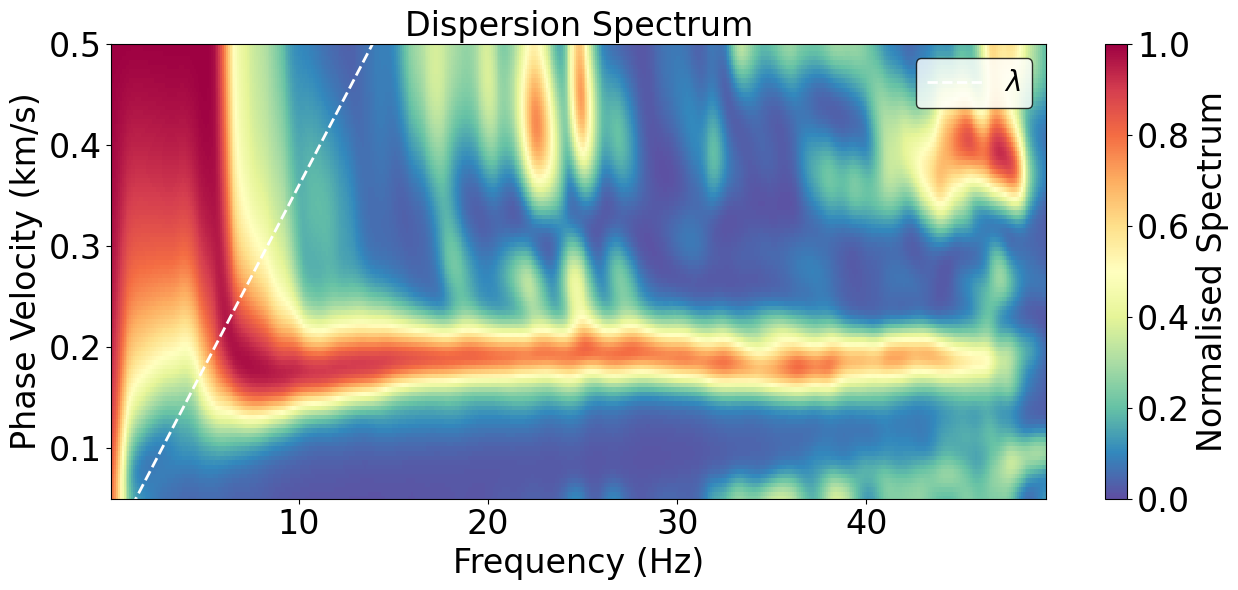

In [2]:
ccf_dir = Path("./CCF")

_, *_ = park_from_dir(ccf_dir, 
              freq_min=0.1, # Hz
              freq_max=45, 
              vel_min=50,   # m/s
              vel_max=500,  
              num_vel=101,  # number of velocity to scan
              part="left"   # ccf part: left (acausal) or right (causal)
              )

### 🕶️ High-resolution linear Radon transform

Solving frequencies: 100%|██████████| 103/103 [00:02<00:00, 38.79it/s]


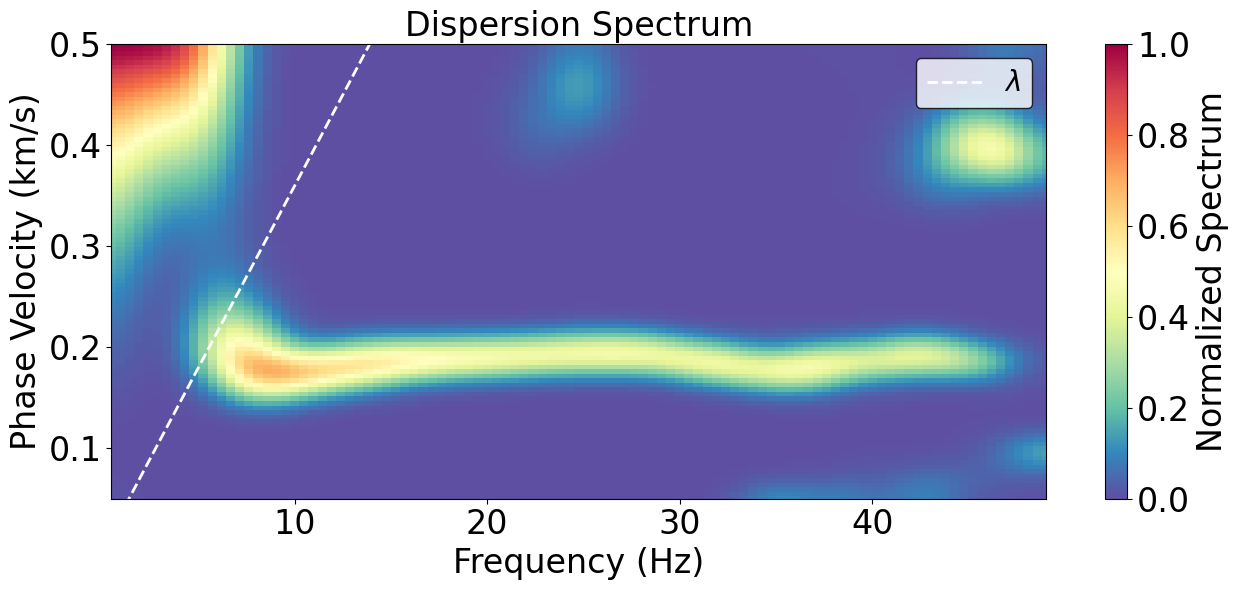

In [4]:
_, *_  = radon_from_dir(ccf_dir, 
              freq_min=0.1, # Hz
              freq_max=45, 
              vel_min=50,   # m/s
              vel_max=500,  
              num_vel=101,  # number of velocity to scan
              part="left",  # ccf part: left (acausal) or right (causal)
              method='L1',
              tol=1e-4,
              reg_lambda=10,
              )

### You should install CC-Fj first and then run the cell below, click https://github.com/ColinLii/CC-FJpy

/media/wdp/disk4/git/noiseba/src/noiseba/dispersion/fj.py:124: ComplexWarning: Casting complex values to real discards the imaginary part
  ccfj.fj_noise(


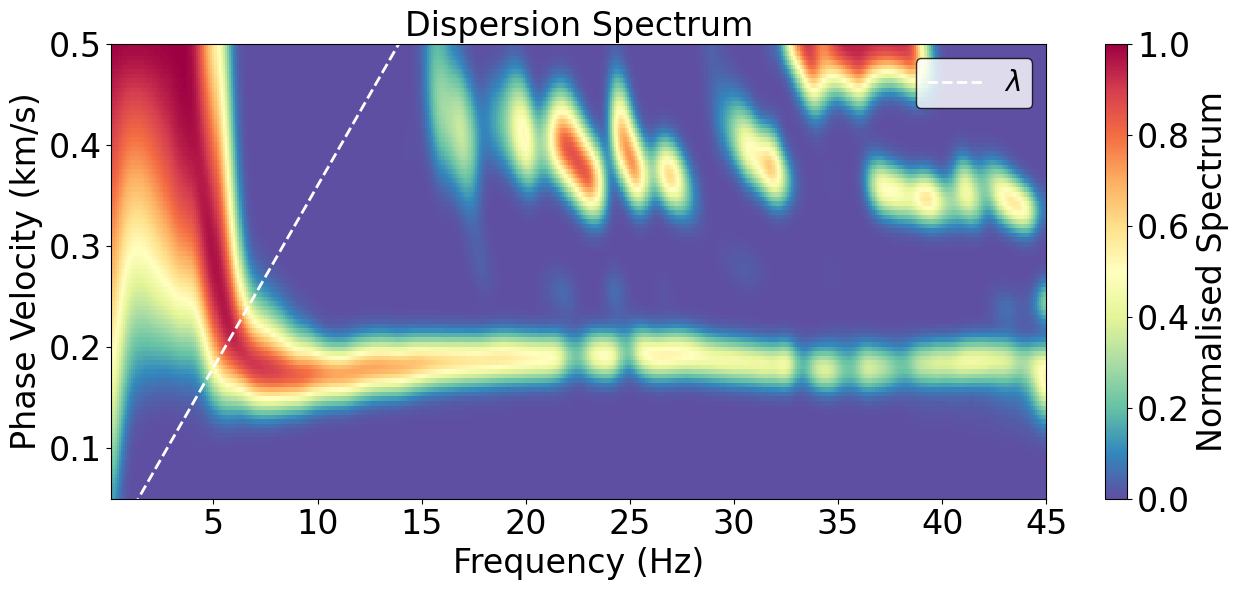

In [3]:
_, *_ = fj_from_dir(ccf_dir, 
              freq_min=0.1, # Hz
              freq_max=45, 
              vel_min=50,   # m/s
              vel_max=500,  
              num_vel=101,  # number of velocity to scan
              part="left",  # ccf part: left (acausal) or right (causal)
              njobs=8,
              )